In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from matplotlib import pyplot
import seaborn as sns

# hyperparameters turning
from ray import tune, train, ray
from ray.tune.schedulers import ASHAScheduler
ray.init(log_to_driver=False)

#Plotting 
from pandas.plotting import scatter_matrix

#Libraries for Statistical Models
import statsmodels.api as sm

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

import os

pd.options.display.max_columns = None
pd.options.display.expand_frame_repr = False

_TARGET_STK = 'MSFT'
data_dir = './data/'

2024-01-26 16:27:51,470	INFO worker.py:1724 -- Started a local Ray instance.


In [2]:
from datetime import datetime
import yfinance as yfin

# Loading the data
stk_tickers = [_TARGET_STK]
idx_tickers = ['VIXCLS', 'SP500', 'DJIA']

start = datetime(2014, 1, 1)
end = datetime(2023, 12, 31)

stk_file = f"{data_dir}{_TARGET_STK}.csv"
if os.path.isfile(stk_file):
    stk_data = pd.read_csv(stk_file).set_index('Date')
    print(f"read {stk_file} completely!")
else:
    # stk_data = web.get_data_yahoo(stk_tickers, start, end)
    stk_data = yfin.download(stk_tickers, start, end).dropna()
    stk_data.to_csv(stk_file)
    print(f"download {_TARGET_STK} from yfin and write to {stk_file} completely!")
    
idx_file = f"{data_dir}{'_'.join(idx_tickers)}.csv"
if os.path.isfile(idx_file):
    idx_data = pd.read_csv(idx_file).set_index('DATE')
    print(f"read {idx_file} completely!")
else:
    idx_data = web.DataReader(idx_tickers, 'fred', start, end).dropna()
    idx_data.to_csv(idx_file)
    print(f"download {idx_tickers} from yfin and write to {idx_file} completely!")

print(stk_data)
print(idx_data)

read ./data/MSFT.csv completely!
read ./data/VIXCLS_SP500_DJIA.csv completely!
                  Open        High         Low       Close   Adj Close    Volume
Date                                                                            
2014-01-02   37.349998   37.400002   37.099998   37.160000   31.290817  30632200
2014-01-03   37.200001   37.220001   36.599998   36.910000   31.080307  31134800
2014-01-06   36.849998   36.889999   36.110001   36.130001   30.423492  43603700
2014-01-07   36.330002   36.490002   36.209999   36.410000   30.659275  35802800
2014-01-08   36.000000   36.139999   35.580002   35.759998   30.111942  59971700
...                ...         ...         ...         ...         ...       ...
2023-12-22  373.679993  375.179993  372.709991  374.579987  374.579987  17091100
2023-12-26  375.000000  376.940002  373.500000  374.660004  374.660004  12673100
2023-12-27  373.690002  375.059998  372.809998  374.070007  374.070007  14905400
2023-12-28  375.369995  376.45

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
validation_size = 0.2
epoch_num = 300
batch_size = 32
log_dir_base = f'{os.getcwd()}/runs/{_TARGET_STK}'
log_dir = log_dir_base
print(log_dir)

/mnt/AIWorkSpace/work/fin-ml/runs/MSFT


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
class LSTMDataSet(Dataset):
    def __init__(self, X, Y, seq_len):
        self.X = X
        self.Y = Y
        self.seq_len = seq_len
    def __len__(self):
        return len(self.X) - self.seq_len + 1
    
    def __getitem__(self, idx):
        return (torch.tensor(np.array(self.X[idx: idx + self.seq_len]), dtype=torch.float32),
                torch.tensor(np.array(self.Y.iloc[idx + self.seq_len - 1,:]), dtype=torch.float32))


In [5]:
from torch import nn
class StockPricePredictionLSTM(nn.Module):
    def __init__(self, seq_len, input_size, hidden_size, num_layers, num_fc_layers, activation_type):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        """
            input_size    : The number of expected features in the input x
            hidden_size   : The number of features in the hidden state h
            num_layers    : Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1
            bias          : If False, then the layer does not use bias weights b_ih and b_hh. Default: True
            batch_first   : If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False
            dropout       : If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0
            bidirectional : If True, becomes a bidirectional LSTM. Default: False
            proj_size     : If > 0, will use LSTM with projections of corresponding size. Default: 0
        """
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        layers = []
        in_features = self.hidden_size
        for i in range(1, num_fc_layers):
            out_features = int(in_features / 2)
            if (out_features <= 1):
                break
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU() if activation_type == 1 else
                          nn.Sigmoid()) if activation_type == 2 else nn.Tanh()
            in_features = out_features

        layers.append(nn.Linear(in_features, 1))
        self.fc = nn.Sequential(*layers)
        self.fc.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            initrange = 0.5
            nn.init.uniform_(m.weight, -initrange, initrange)
            nn.init.zeros_(m.bias)
            # print(f"{m.in_features},{m.out_features}")

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))

        fc_input = h_out[-1].view(-1, self.hidden_size)
        return self.fc(fc_input)


In [6]:
import math 
from sklearn.metrics import mean_squared_error

def eval_dl_method(model, dl, criterion=None, device=device):
    model.eval()
    y_gt = []
    y_pred = []
    vloss = 0.0
    for i, (x, y) in enumerate(dl):
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        if criterion != None:
            vloss += criterion(outputs, y).item()
        # print(f"{i}:{vloss}")
        y_gt.extend(y.cpu().detach().numpy().reshape(-1))
        y_pred.extend(outputs.cpu().detach().numpy().reshape(-1))
    
    return (math.sqrt(mean_squared_error(y_gt, y_pred)) if np.isnan(y_pred).any() == False else 9999, y_gt, y_pred, vloss)


In [7]:
def prepare_buy_sell_signal():
    buy_sell_signal = stk_data[[]].copy()
    sma = pd.concat([stk_data.ta.sma(close='Adj Close', length=10), stk_data.ta.sma(close='Adj Close', length=60)], axis=1).dropna()
    buy_sell_signal['Signal'] = (sma['SMA_10'] > sma['SMA_60']).astype('float32')
    return buy_sell_signal

def gen_analysis_data(stock_name, return_period):
    import pandas_ta
    data = stk_data
    
    data = pd.concat([data.ta.percent_return(length=return_period, prefix=stock_name),
                        data.ta.adosc(prefix=stock_name),
                        data.ta.kvo(prefix=stock_name), 
                        data.ta.rsi(close='Adj Close', length=10, prefix=stock_name)/100,
                        data.ta.rsi(close='Adj Close', length=30, prefix=stock_name)/100,
                        data.ta.rsi(close='Adj Close', length=200, prefix=stock_name)/100,
                        data.ta.stoch(k=10, prefix=stock_name)/100,
                        data.ta.stoch(k=30, prefix=stock_name)/100,
                        data.ta.stoch(k=200, prefix=stock_name)/100],
                        axis=1)
    data = data.dropna().astype('float32')
    return data, data.columns[:-9].values, data.columns[-9:].values


In [ ]:
import pandas_ta
pd.set_option('display.max_rows', None)
buy_sell_signal = stk_data[[]].copy()
s = pd.concat([stk_data.ta.sma(close='Adj Close', length=10), stk_data.ta.sma(close='Adj Close', length=60)], axis=1).dropna()
print(s.reset_index().head(70))
buy_sell_signal['signal'] = (s['SMA_10'] > s['SMA_60']).astype('float32')
print(buy_sell_signal.head(70))

In [8]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn_pandas import DataFrameMapper

def prepare_dataloader(return_period, seq_len):
    Target_Data, un_standardized, standardized = gen_analysis_data(_TARGET_STK, 5)
    buy_sell_signal = prepare_buy_sell_signal()

    standardized = np.append(standardized, buy_sell_signal.columns.values)

    X1 = pd.concat([Target_Data, buy_sell_signal], axis=1)
    X3 = pd.concat([idx_data['SP500'].pct_change(return_period), idx_data['DJIA'].pct_change(return_period)], axis=1)
    X3 = X3.rename(columns={ column : f"{column}_PCTRET_{return_period}" for column in X3.columns.to_list()})
    X3 = pd.concat([idx_data['VIXCLS'], X3], axis=1).dropna()
    X1_X3 = pd.concat([X1, X3], axis=1).dropna()

    Y_raw = stk_data.loc[:, 'Adj Close'].to_frame().pct_change(return_period).shift(-return_period).dropna().astype('float32')
    Y_raw.columns = [f"{_TARGET_STK}_pred_{return_period}"]

    dataset = pd.concat([X1_X3, Y_raw], axis=1).dropna()

    X = dataset.loc[:, X1_X3.columns]
    Y = dataset.loc[:, Y_raw.columns]

    train_size = int(len(X) * (1 - validation_size))
    X_train = X.iloc[0:train_size]
    Y_train = Y.iloc[0:train_size]
    X_test  = X.iloc[train_size - seq_len + 1:len(X)]
    Y_test  = Y.iloc[train_size - seq_len + 1:len(Y)]

    features = [([column], StandardScaler()) for column in un_standardized]
    features.extend([([column], StandardScaler()) for column in X3.columns.values])
    features.extend([([column], None) for column in standardized])
    X_dfm = DataFrameMapper(        
        features,
        input_df=True, df_out=True)
    X_train = X_dfm.fit_transform(X_train)
    X_test = X_dfm.transform(X_test)

    train_loader = DataLoader(LSTMDataSet(X_train, Y_train, seq_len), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(LSTMDataSet(X_test, Y_test, seq_len), batch_size=batch_size)

    return train_loader, test_loader


In [ ]:
train, test = prepare_dataloader(5, 3)
print(train.dataset.X.head(10))
print(train.dataset.Y)

In [9]:
def save_model(model, config, file_path):
    state = {
        'time': str(datetime.now()),
        'model_state': model.state_dict(),
        'input_size': model.input_size,
        'config': config            
    }
    torch.save(state, file_path)

def load_model(file_path):
    data_dict = torch.load(file_path)
    config = data_dict['config']    
    model = StockPricePredictionLSTM(config['seq_len'], input_size=data_dict['input_size'],
                                     hidden_size=int(config['hidden_size']),num_layers=int(config['num_layers']),
                                     num_fc_layers=int(config['num_fc_layers']), activation_type=int(config['activation_type']))

    model.load_state_dict(data_dict['model_state'])
    return model, config


In [10]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings('ignore')

def do_train(model, optimizer, train_dl, test_dl, id_str, config, writer):
    criterion = torch.nn.MSELoss()

    model_name = f"{log_dir}/{id_str}.pt"
    best_loss = 999999999    
    total_loss = 0.0
    total_vloss = 0.0
    for epoch in tqdm(range(epoch_num)):
        model.train()
        running_loss = 0.0
        
        for i, (x, y) in enumerate(train_dl):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if loss.item() < best_loss:
                best_loss = loss.item()
                save_model(model, config, model_name)

        with torch.no_grad():
            (testScore, test_y_gt, test_y_pred, running_vloss)  = eval_dl_method(model, test_dl, criterion)
            train.report({"mse_score":testScore})
            
        writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : running_loss / len(train_dl), 'Validation' : running_vloss / len(test_dl) },
                            epoch + 1)
        total_loss += running_loss / len(train_dl)
        total_vloss += running_vloss / len(test_dl)

        writer.flush()
        
    return {'Train loss':total_loss/epoch_num, 'Validation loss': total_vloss/epoch_num}

def train_LSTM(config):
    return_period = config["return_period"]
    seq_len = config["seq_len"]
    lr = config["lr"]
    momentum = config["momentum"]
    optim_type = config["optim_type"]
    num_layers = config["num_layers"]
    hidden_size = config["hidden_size"]
    num_fc_layers = config["num_fc_layers"]
    activation_type = config["activation_type"]

    id_str = "_".join(str(v) if v < 1 else f'{v:g}' for v in config.values())
    print(id_str)
    writer = SummaryWriter(f"{log_dir}/{id_str}")    

    train_loader, test_loader = prepare_dataloader(return_period, seq_len)
    model = StockPricePredictionLSTM(seq_len, input_size=len(train_loader.dataset.X.columns),
                                     hidden_size=hidden_size,num_layers=num_layers,
                                     num_fc_layers=num_fc_layers, activation_type=activation_type)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) if optim_type == 1 else torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    metric_dict = do_train(model, optimizer, train_loader, test_loader, id_str, config, writer)
    writer.add_hparams(
        config,
        metric_dict
    )
    writer.close()


2024-01-25 10:29:54.345962: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-25 10:29:54.347099: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-25 10:29:54.368014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-25 10:29:54.697645: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [47]:
time_str = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
log_dir = f'{log_dir_base}/{time_str}'
epoch_num = 600
config={
    "return_period":5,
    "seq_len":3,
    "lr":0.001,
    "momentum":0.32400661960813776,
    "optim_type":2,
    "num_layers":4,
    "hidden_size":128,
    "num_fc_layers":1,
    "activation_type":2
}
print(log_dir)
train_LSTM(config)

/mnt/AIWorkSpace/work/fin-ml/runs/MSFT/2024-01-25_10.19.36
5_3_0.001_0.32400661960813776_2_4_128_1_2


100%|██████████| 600/600 [02:38<00:00,  3.80it/s]


In [11]:
search_space = {
    "return_period": tune.grid_search([3, 5]), #[2,3,5,10]
    "seq_len": tune.grid_search([3, 5, 10]),
    "lr": tune.grid_search([0.01]), #[0.001, 0.01, 0.1]
    "momentum": tune.uniform(0.1, 0.9),
    "optim_type": tune.grid_search([2]), # [1, 2]
    "num_layers": tune.grid_search([2, 4, 8, 16]), #[1, 2, 4, 8]
    "hidden_size": tune.grid_search([32, 64, 128, 256]), #[8, 16, 32, 64, 128]
    "num_fc_layers": tune.grid_search([1, 2, 3]), #1, 2, 3]),
    "activation_type": tune.grid_search([1, 2, 3]) #, 2, 3])
}

turning_parameters = []
total_configs = 1
for k, v in search_space.items():
    if type(v).__name__ == 'dict' and list(v.keys())[0] == 'grid_search' and len(list(v.values())[0]) > 1:
        turning_parameters.append(k)
        total_configs *= len(list(v.values())[0])
print(turning_parameters)
print(f"Total count of configs = {total_configs}")


['return_period', 'seq_len', 'num_layers', 'hidden_size', 'num_fc_layers', 'activation_type']
Total count of configs = 864


In [55]:
import warnings
warnings.filterwarnings('ignore', category=Warning)

time_str = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
log_dir = f'{log_dir_base}/{time_str}'

analysis = tune.run(train_LSTM, 
                    config=search_space,
                    resources_per_trial={'cpu':0.1, 'gpu':0.1},
                    metric="mse_score",
                    mode="min")

2024-01-25 10:28:56,320	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,mse_score
train_LSTM_9974f_00000,0.0325145
train_LSTM_9974f_00001,0.0332042
train_LSTM_9974f_00002,0.0381277
train_LSTM_9974f_00003,0.0331876
train_LSTM_9974f_00004,0.0334818
train_LSTM_9974f_00005,0.0327862
train_LSTM_9974f_00006,0.0321687
train_LSTM_9974f_00007,0.0325145
train_LSTM_9974f_00008,0.0330146
train_LSTM_9974f_00009,0.0327274


2024-01-25 10:29:08,398	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-01-25 10:29:08,740	INFO tune.py:1042 -- Total run time: 12.42 seconds (12.07 seconds for the tuning loop).
2024-01-25 10:29:08,741	WARNING tune.py:1057 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2024-01-25 10:29:08,757	WARNING experiment_analysis.py:193 -- Failed to fetch metrics for 35 trial(s):
- train_LSTM_9974f_00010: FileNotFoundError('Could not fetch metrics for train_LSTM_9974f_00010: both result.json and progress.csv were not found at /home/skchen/ray_results/train_LSTM_2024-01-25_10-28-56/train_LSTM_9974f_00010_10_activation_type=2,hidden_size=256,lr=0.0100,momentum=0.2593,num_fc_layers=1,num_layers=2,optim_type=2,re_2024-01-25_10-28-56')
- train_LSTM_9974f_0001

In [22]:
mse_list = []
trial_list = list(analysis.trial_dataframes.values())
for i, trial in enumerate(trial_list):
    # if trial.empty == False:
    d = pd.DataFrame.from_dict({"mse_score": trial.describe().loc['mean', 'mse_score'], "trial_id": trial.loc[0:0,'trial_id'] })
    # else:
    #     d = pd.DataFrame.from_dict({"mse_score": [np.NaN], "trial_id": [np.NaN]})
    mse_list.append(d)
mse_df = pd.concat(mse_list)
mse_df = mse_df.reset_index().loc[:, ["mse_score", "trial_id"]]
print(mse_df)


     mse_score     trial_id
0     0.040280  de043_00000
1     0.040462  de043_00001
2     0.042003  de043_00002
3     0.044053  de043_00003
4     0.039018  de043_00004
..         ...          ...
103   0.043211  de043_00103
104   0.039198  de043_00104
105   0.039137  de043_00105
106   0.039152  de043_00106
107   0.040072  de043_00107

[108 rows x 2 columns]


In [23]:
import shutil

config_df = pd.DataFrame(analysis.get_all_configs().values())
# print(config_df)
results = pd.concat([mse_df, config_df], axis=1)
# print(results)

sorted_results = results.sort_values(by="mse_score")
# print(sorted_results.head(100))
sorted_results_file = f"{_TARGET_STK}_sorted_results.csv"
sorted_results.to_csv(sorted_results_file)

best_config = config_df.iloc[sorted_results.index[0]].to_dict()
id_str = "_".join(str(v) if v < 1 else f'{v:g}' for v in best_config.values())
best_model_name = f"{log_dir}/{id_str}.pt"
print(best_model_name)
shutil.copy(best_model_name, f"{_TARGET_STK}.pt")

# summary = pd.DataFrame(index=sorted_results.describe().index.values)
# for hperparameter_name in turning_parameters: #['optim_type', 'num_layers', 'hidden_size', 'num_fc_layers', 'activation_type']:
#     parameter_group = sorted_results.groupby(hperparameter_name)
#     for g in parameter_group:
#         summary[f"{hperparameter_name}_{g[0]}"] = g[1].describe()['mse_score']
# print(summary)



/mnt/AIWorkSpace/work/fin-ml/runs/MSFT/2024-01-25_09.26.25/5_3_0.01_0.4248162461717875_2_4_128_1_2.pt


'MSFT.pt'

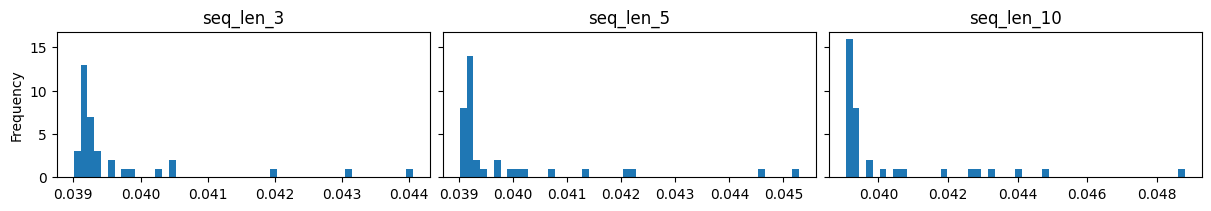

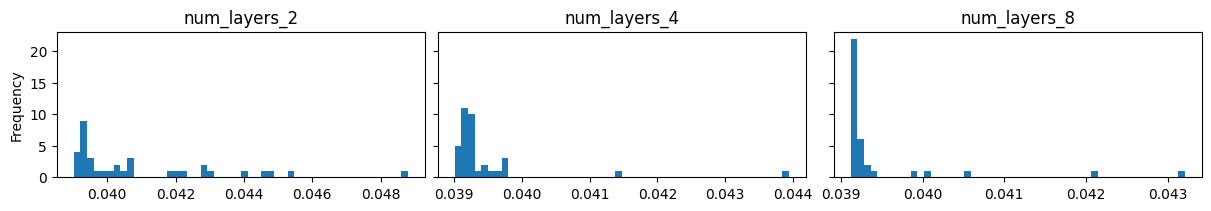

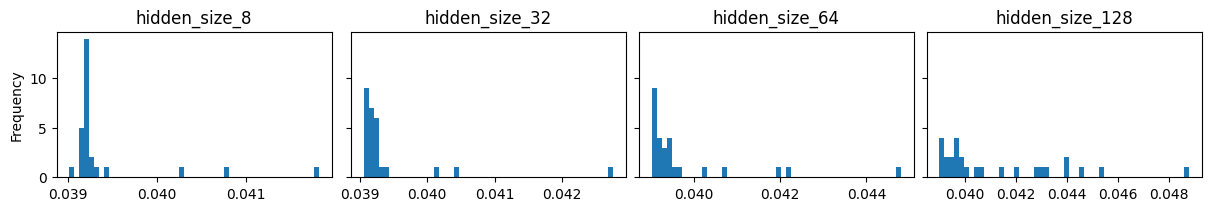

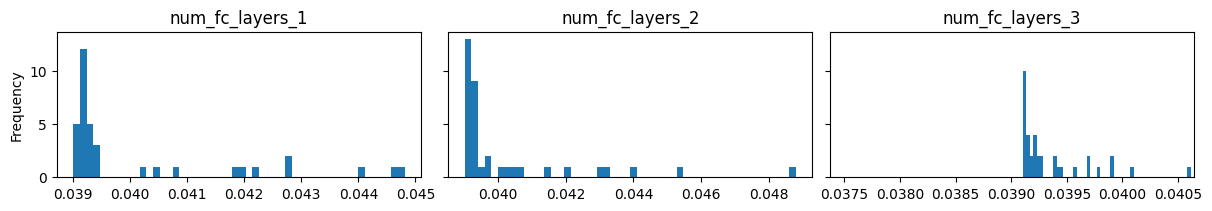

In [24]:
mse_desc = sorted_results['mse_score'].astype('float32').describe()
xlimit_range = [mse_desc['min'] - mse_desc['std'], mse_desc['max'] + mse_desc['std']]
for hperparameter_name in turning_parameters:
    parameter_group = sorted_results.groupby(hperparameter_name)
    fix, axs = pyplot.subplots(1, len(parameter_group), layout='constrained', sharex=False, sharey=True, figsize=(12,2))
    for i, g in enumerate(parameter_group):
        g[1]['mse_score'].astype('float32').plot(kind='hist',bins=50, subplots=True,sharex=False,sharey=True,ax=axs[i])
        axs[i].set_title(f"{hperparameter_name}_{g[0]}")
        
pyplot.xlim(xlimit_range)
pyplot.show()

In [10]:
sorted_results_file = f"{_TARGET_STK}_sorted_results.csv"
sorted_results = pd.read_csv(sorted_results_file, dtype='str')
best_config = sorted_results.loc[0]
print(best_config)
# id_str_of_best = f"5_5_0.01_{best_config.momentum}_{best_config.optim_type}_{best_config.num_layers}_{best_config.hidden_size}_{best_config.num_fc_layers}_{best_config.activation_type}"
# best_model_name = f"/mnt/AIWorkSpace/work/fin-ml/runs/{_TARGET_STK}/{time_str}/{id_str_of_best}.pt"
# print(best_model_name)

Unnamed: 0                          50
mse_score          0.03178376515414065
trial_id                   bf758_00050
return_period                        3
seq_len                              3
lr                                0.01
momentum           0.41067475256907493
optim_type                           2
num_layers                           4
hidden_size                         32
num_fc_layers                        2
activation_type                      3
Name: 0, dtype: object


In [11]:
import math 
from sklearn.metrics import mean_squared_error

pd.set_option('display.precision', 5)

model, config = load_model(f"{_TARGET_STK}.pt")
model.to(device)

train_loader, test_loader = prepare_dataloader(config["return_period"], config["seq_len"])
model.eval()

(trainScore, train_y_gt, train_y_pred, _)= eval_dl_method(model, train_loader, device=device)
(testScore, test_y_gt, test_y_pred, _)  = eval_dl_method(model, test_loader, device=device)
print(test_y_pred)
print(f"Train RMSE: {trainScore:.2f}\nTest RMSE: {testScore:.5f}")


[0.0035049971, 0.002215052, 0.0007411856, 0.000300264, 0.0009384509, 0.0019202065, 0.002023207, 0.0024417136, 0.0028965492, 0.0034006853, 0.0023231748, 0.0012216289, 0.0013261195, 0.0012737047, 0.0004407782, -0.0008095894, -0.0009123832, -0.00015573017, 0.0010001641, 0.0022754427, 0.0030992161, 0.0037038494, 0.0030143913, 0.0027349424, 0.0022609644, 0.0027441252, 0.0034625996, 0.0043845978, 0.0045039747, 0.0044077914, 0.0047892723, 0.00506589, 0.0045846123, 0.003960328, 0.0037621427, 0.0032218155, 0.0025418568, 0.0022708047, 0.0014626645, 0.00060187094, 0.0009894129, 0.002370244, 0.0033557247, 0.0029289369, 0.0019185003, 0.00016950257, -0.00014425628, 0.00041681714, -8.754432e-06, -0.0002135504, -1.1680648e-05, 0.0026935954, 0.0036087278, 0.0043081883, 0.0033415686, 0.0031587984, 0.0016564708, -4.859641e-06, -0.00019499846, 0.0010163207, 0.0033707935, 0.0030642245, 0.002069516, 0.00029283017, 0.00038059615, -5.9871003e-05, -0.00014051981, -0.00013655983, 0.000984868, 0.002168307, 0.003

<bound method NDFrame.head of                  Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2022-02-22  285.00000  291.54001  284.50000  287.72000  283.12796  41736100
2022-02-23  290.17999  291.70001  280.10001  280.26999  275.79688  37811200
2022-02-24  272.51001  295.16000  271.51999  294.59000  289.88834  56989700
2022-02-25  295.14001  297.63000  291.64999  297.31000  292.56494  32546700
2022-02-28  294.31000  299.14001  293.00000  298.79001  294.02127  34627500
...               ...        ...        ...        ...        ...       ...
2023-12-19  371.48999  373.26001  369.84000  373.26001  373.26001  20603700
2023-12-20  375.00000  376.03000  370.53000  370.62000  370.62000  26316700
2023-12-21  372.56000  374.41000  370.04001  373.54001  373.54001  17708000
2023-12-22  373.67999  375.17999  372.70999  374.57999  374.57999  17091100
2023-12-26  375.00000  376.94000  373.50000  374.66000  37

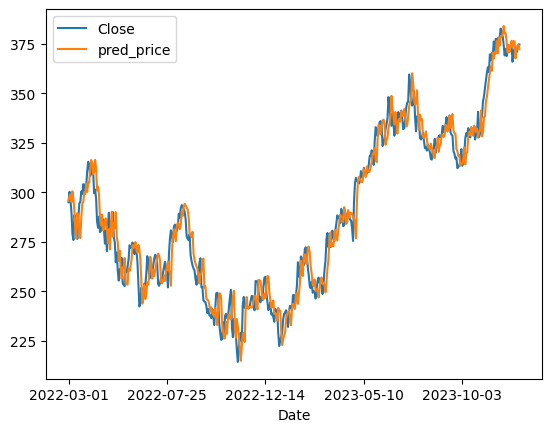

In [12]:
target_raw = stk_data.loc[test_loader.dataset.X.index.values]
print(target_raw.head)
target_raw = target_raw.drop(target_raw.index[range(config["seq_len"] - 1)], axis=0)

test_y_pred_df = pd.DataFrame(index=target_raw.index.copy())
test_y_pred_df['pred_price'] = test_y_pred
test_y_pred_df['pred_price'] = (test_y_pred_df['pred_price'] + 1) * target_raw['Close']
test_y_pred_df = test_y_pred_df.shift(config["return_period"])
tmp_data = pd.concat([target_raw, test_y_pred_df], axis=1).dropna()
tmp_data['Close'].plot()
tmp_data['pred_price'].plot()
pyplot.legend()
pyplot.show()


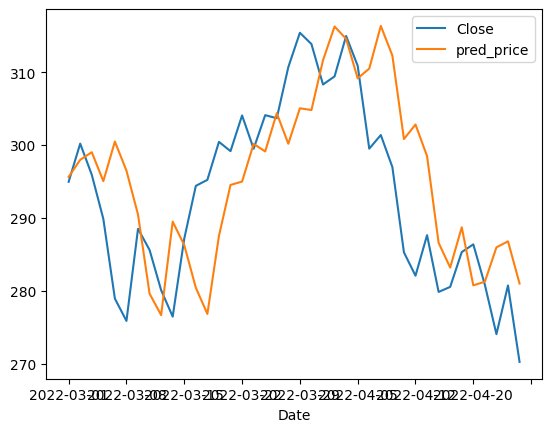

In [13]:
target_raw = stk_data.loc[test_loader.dataset.X.index.values]
# print(target_raw.head(10))
target_raw = target_raw.drop(target_raw.index[range(config["seq_len"] - 1)], axis=0)
# print(target_raw.head(10))

test_y_pred_df = pd.DataFrame(index=target_raw.index.copy())
test_y_pred_df['pred_price_change'] = test_y_pred
# print(test_y_pred_df.head(10))
test_y_pred_df['pred_price'] = (test_y_pred_df['pred_price_change'] + 1) * target_raw['Close']
# print(test_y_pred_df.head(10))
# print(test_y_gt[:10])
test_y_pred_df = test_y_pred_df.shift(config["return_period"])
# print(test_y_pred_df.head(10))
tmp_data = pd.concat([target_raw, test_y_pred_df], axis=1).dropna()
tmp_data['Close'].iloc[:40].plot()
tmp_data['pred_price'].iloc[:40].plot()
pyplot.legend()
pyplot.show()
